## LAB 4 - classifiers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models import MLClassifier, ParzenClassifer, KNNClassifier
from utils import confusion_matrix, error_score, normalize_data
from visualization import plot_2D, plot_3D

plt.rcParams['figure.figsize'] = [16, 7]

## 2 classes - 2 dimensions 

In [3]:
X, Y = np.load('data/lab4.p', allow_pickle=True)

Throughout this lab, we will convert the data samples in a canonical data structutre better suited for classification. This allow us to implement [classification models](models.py) following the style of scikit-learn's  API. The main advantage is that our models are scalable for any number of classes, and can be applied to samples of any dimension. For each classification task, we will `fit` the model to the training data, and `predict` the class of unseen samples, even though `fit` and `predict` do different things for each model.

In [4]:
x_train, x_test, y_train, y_test = normalize_data(X, Y)

This implementation design also allows us to check our results directly against sklearn's models, using the following method.

In [5]:
def train_test_evaluate(models):
    global x_train, x_test, y_train, y_test
    
    results = {
        'P( error )':{},
    }
    
    for desc, m in models.items():
        model = m['class'](**m['kwargs'])
        model.fit(x_train, y_train)
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)
        err_train = error_score(y_pred_train, y_train)
        err_test = error_score(y_pred_test, y_test)
        cm_train = confusion_matrix(y_pred_train, y_train)
        cm_test = confusion_matrix(y_pred_test, y_test)

        variant = ['Reclassification', 'Testing']
        error = [err_train, err_test]
        confusion = [cm_train, cm_test]

        for var, err, cm in zip(variant, error, confusion):
            row_name = f'{desc} {var}'
            results['P( error )'][row_name]= f'{err:.2f}'
            for i, p_correct in enumerate(cm.diagonal()):
                true_positives = f'P( correct | w_{i+1} )'
                if true_positives not in results:
                    results[true_positives] = {}
                results[true_positives][row_name]= f'{p_correct:.2f}'
        
    return pd.DataFrame(results)

,P( error ),P( correct | w_1 ),P( correct | w_2 )
Maximum likelihood Reclassification,0.05,0.97,0.94
Maximum likelihood Testing,0.10,0.93,0.85
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.19,0.92,0.64
Parzen h1 = 5.0 Reclassification,0.04,0.95,0.99
Parzen h1 = 5.0 Testing,0.10,0.92,0.86
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.11,0.93,0.84
Nearest neighbours k = 5 Reclassification,0.03,0.97,0.97
Nearest neighbours k = 5 Testing,0.10,0.93,0.86


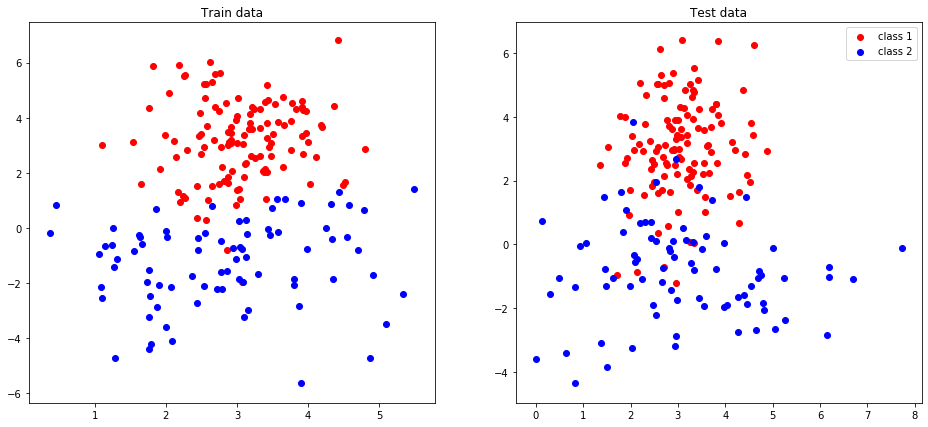

In [6]:
models = {
    "Maximum likelihood" : {'class':MLClassifier, 'kwargs' : {}},
    "Parzen h1 = 0.1" : {'class':ParzenClassifer, 'kwargs' : {'h':0.1}},
    "Parzen h1 = 5.0" : {'class':ParzenClassifer, 'kwargs' : {'h':5.0}},
    "Nearest neighbours k = 1" : {'class':KNNClassifier, 'kwargs' : {'k':1}},
    "Nearest neighbours k = 5" : {'class':KNNClassifier, 'kwargs' : {'k':5}}
}

plot_2D(X, Y)
train_test_evaluate(models)

We can check the consistency of our results by comparing them against scikit-learn models. 
Unfortunately, scikit-learn does not implement a Parzen classifier. The density estimation function is not the same neither in the book nor in the lecture notes, so the one we use is defined below. 


\begin{align*}
p_N = \frac{k_N}{N}
\end{align*}


where


\begin{align*}
k_N &= \sum_{i=1}^N \frac{1}{V_N} \varphi(\frac{x-x_i}{h_N}) \\
N &= \text{number of samples of dimension } d \\
V_N &= h_N^d \\
h_N &= \frac{h_1} {\sqrt{N}} \\
\end{align*}


We use a gaussian kernel as our window function $\varphi$, with parameters $\mu = \begin{bmatrix} 0 \\ 0\end{bmatrix}$ and $\Sigma = I_d$, i.e.


\begin{align*}
\varphi(u) 
&= 2\pi^{-\frac{d}{2}} \det(\Sigma)^{-\frac{1}{2}} e^{-\frac{1}{2} (u-\mu)^T \Sigma^{-1} (u-\mu)} \\
&= 2\pi^{-\frac{d}{2}} e^{-\frac{1}{2} u^T u}
\end{align*}


In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

sklearn_models = {
    "sklearn ML" : {'class':GaussianNB, 'kwargs' : {'var_smoothing':0}},
    "sklearn KNN k = 1" : {'class':KNeighborsClassifier, 'kwargs' : {'n_neighbors':1}},
    "sklearn KNN k = 5" : {'class':KNeighborsClassifier, 'kwargs' : {'n_neighbors':5}}
}


train_test_evaluate(sklearn_models)

,P( error ),P( correct | w_1 ),P( correct | w_2 )
sklearn ML Reclassification,0.05,0.97,0.93
sklearn ML Testing,0.09,0.93,0.88
sklearn KNN k = 1 Reclassification,0.00,1.00,1.00
sklearn KNN k = 1 Testing,0.11,0.93,0.84
sklearn KNN k = 5 Reclassification,0.03,0.97,0.97
sklearn KNN k = 5 Testing,0.10,0.93,0.86


For the Maximum Likelihood and k-nearest neighbours, our results match the results of scikit learn.

## 3 classes - 2 dimensions 

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 )
Maximum likelihood Reclassification,0.47,0.48,0.76,0.20
Maximum likelihood Testing,0.54,0.28,0.78,0.07
Parzen h1 = 0.1 Reclassification,0.05,0.92,0.94,1.00
Parzen h1 = 0.1 Testing,0.63,0.48,0.34,0.33
Parzen h1 = 5.0 Reclassification,0.41,0.76,0.56,0.50
Parzen h1 = 5.0 Testing,0.58,0.60,0.42,0.27
Nearest neighbours k = 1 Reclassification,0.05,1.00,0.90,1.00
Nearest neighbours k = 1 Testing,0.62,0.24,0.48,0.33
Nearest neighbours k = 5 Reclassification,0.27,0.76,0.78,0.63
Nearest neighbours k = 5 Testing,0.63,0.16,0.56,0.23


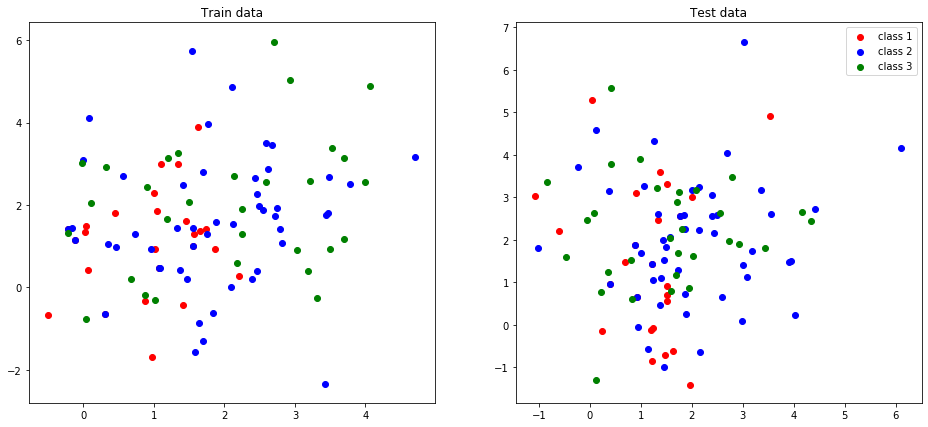

In [8]:
X_2D3cl, _, _, _, _, Y_2D3cl, _, _, _, _ = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_2D3cl, Y_2D3cl)

plot_2D(X_2D3cl, Y_2D3cl)
train_test_evaluate(models)

For this classification task, all testing classifiers perform very poorly. It seems understandable as the three classes seems to be drawn from a nearly identical distribution. However, we observe that the maximum likelihood classifier is the one having the smallest difference of error between reclassification and testing, which could mean that it is less likely to overfit the training data.

## 4 classes - 2 dimensions - low separability

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 ),P( correct | w_4 )
Maximum likelihood Reclassification,0.57,0.40,0.56,0.44,0.32
Maximum likelihood Testing,0.55,0.52,0.52,0.52,0.24
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.74,0.16,0.36,0.24,0.28
Parzen h1 = 5.0 Reclassification,0.52,0.40,0.68,0.28,0.56
Parzen h1 = 5.0 Testing,0.57,0.44,0.52,0.32,0.44
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.74,0.16,0.36,0.24,0.28
Nearest neighbours k = 5 Reclassification,0.27,0.52,0.88,0.80,0.72
Nearest neighbours k = 5 Testing,0.68,0.32,0.40,0.32,0.24


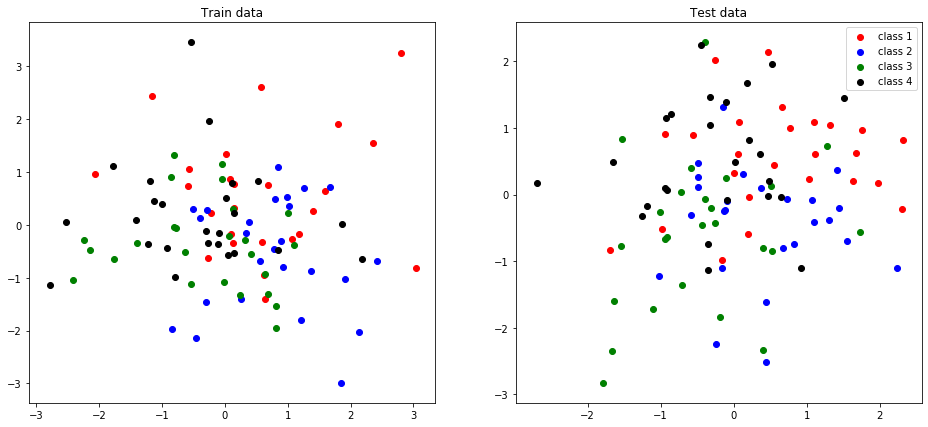

In [9]:
_, X_2D4cl, _, _, _, _, Y_2D4cl, _, _, _ = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_2D4cl, Y_2D4cl)

plot_2D(X_2D4cl, Y_2D4cl)
train_test_evaluate(models)

## 4 classes - 2 dimensions - medium separability

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 ),P( correct | w_4 )
Maximum likelihood Reclassification,0.27,0.72,0.80,0.72,0.68
Maximum likelihood Testing,0.28,0.76,0.80,0.60,0.72
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.43,0.44,0.52,0.60,0.72
Parzen h1 = 5.0 Reclassification,0.26,0.64,0.76,0.76,0.80
Parzen h1 = 5.0 Testing,0.27,0.76,0.76,0.68,0.72
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.41,0.44,0.60,0.60,0.72
Nearest neighbours k = 5 Reclassification,0.16,0.72,0.80,0.96,0.88
Nearest neighbours k = 5 Testing,0.32,0.60,0.76,0.68,0.68


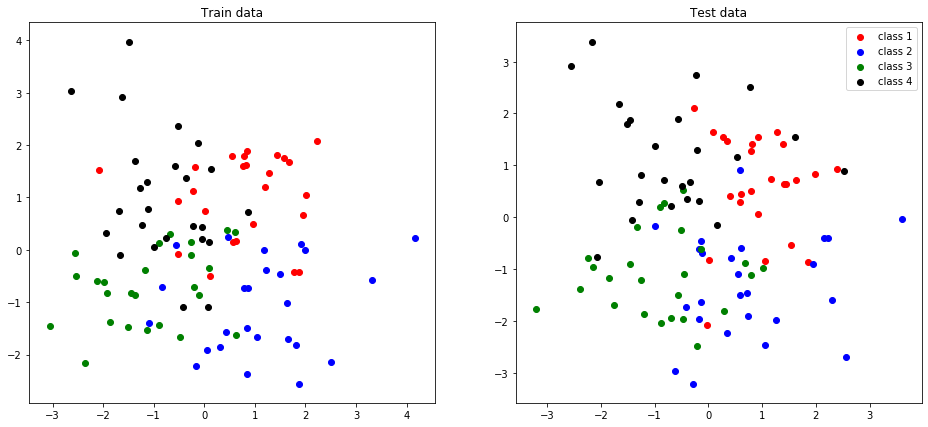

In [10]:
_, _, X_2D4cl_ms, _, _, _, _, Y_2D4cl_ms, _, _ = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_2D4cl_ms, Y_2D4cl_ms)

plot_2D(X_2D4cl_ms, Y_2D4cl_ms)
train_test_evaluate(models)

## 4 classes - 2 dimensions - high separability

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 ),P( correct | w_4 )
Maximum likelihood Reclassification,0.03,0.96,0.96,1.00,0.96
Maximum likelihood Testing,0.06,0.88,0.96,0.96,0.96
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.12,0.84,0.96,0.96,0.76
Parzen h1 = 5.0 Reclassification,0.03,0.92,0.96,1.00,1.00
Parzen h1 = 5.0 Testing,0.08,0.84,0.96,0.96,0.92
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.08,0.84,1.00,0.96,0.88
Nearest neighbours k = 5 Reclassification,0.03,0.92,0.96,1.00,1.00
Nearest neighbours k = 5 Testing,0.07,0.84,0.96,0.96,0.96


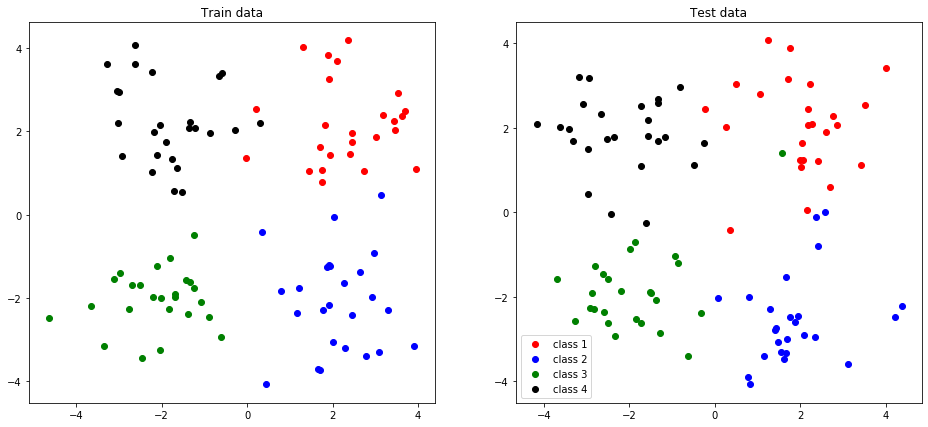

In [11]:
_, _, _, X_2D4cl_hs, _, _, _, _, Y_2D4cl_hs, _ = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_2D4cl_hs, Y_2D4cl_hs)

plot_2D(X_2D4cl_hs, Y_2D4cl_hs)
train_test_evaluate(models)

As classes become more separable, classifiers tend to have a lower error rate overall. We can also observe that Maximum Likelihood and Parzen with a window of 5 tend to have similar performance on reclassification and testing sets. However, Parzen with a smaller window or Nearest neigbours seem to be more sensitive to noise, and overfit the training data.

## 3 classes - 3 dimensions - medium separability

,P( error ),P( correct | w_1 ),P( correct | w_2 ),P( correct | w_3 )
Maximum likelihood Reclassification,0.11,0.88,0.91,0.88
Maximum likelihood Testing,0.25,0.55,0.88,0.82
Parzen h1 = 0.1 Reclassification,0.00,1.00,1.00,1.00
Parzen h1 = 0.1 Testing,0.46,0.67,0.30,0.64
Parzen h1 = 5.0 Reclassification,0.13,0.88,0.88,0.85
Parzen h1 = 5.0 Testing,0.21,0.61,0.88,0.88
Nearest neighbours k = 1 Reclassification,0.00,1.00,1.00,1.00
Nearest neighbours k = 1 Testing,0.23,0.55,0.85,0.91
Nearest neighbours k = 5 Reclassification,0.16,0.85,0.88,0.79
Nearest neighbours k = 5 Testing,0.20,0.61,0.91,0.88


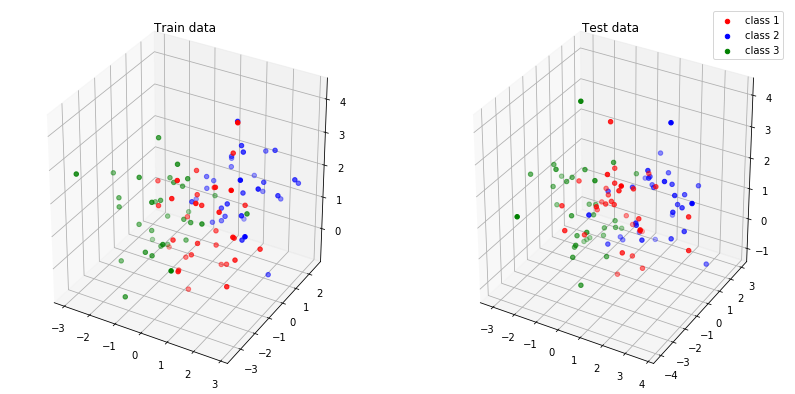

In [12]:
_, _, _, _, X_3D3cl_ms, _, _, _, _, Y_3D3cl_ms = np.load('data/lab4_2.p', allow_pickle=True)
x_train, x_test, y_train, y_test = normalize_data(X_3D3cl_ms, Y_3D3cl_ms)

plot_3D(X_3D3cl_ms, Y_3D3cl_ms)
train_test_evaluate(models)